In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, lit, min, max, mean, stddev
from pyspark.sql.functions import monotonically_increasing_id

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import LinearSVC

import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

from cdc_module import spark_histograms, clean_data, validity_check, calculate_correlation, heatmap, feature_correlation, \
target_histograms, select_corr_features, pca_filter, plot_principal_components, plot_principal_components_3d, plot_pca_with_clusters, \
      plot_eigenvalues, test_train_split, test_and_save_results, plot_absolute_contributions, plot_models_results, plot_explained_variance, balance_dataset

%matplotlib inline


## **5.Machine Learning Algorithms**

In [2]:
# 初始化 SparkSession
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CDC Diabetes Health Indicators") \
    .config("spark.driver.memory", "8g")\
    .master("local[*]") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# 读取 X_explained_variance_components.csv
X_explained_variance_components = spark.read.csv('./X_explained_variance_components.csv', header=True, inferSchema=True)

# 读取 X_elbow_method_components.csv
X_elbow_method_components = spark.read.csv('./X_elbow_method_components.csv', header=True, inferSchema=True)

# 读取 X_no_compound_features.csv
X_no_compound_features = spark.read.csv('./X_no_compound_features.csv', header=True, inferSchema=True)

# 读取 y_pyspark.csv (假设你是将 `y_pyspark` 保存为 CSV 文件)
y_pyspark = spark.read.csv('./y_pyspark.csv', header=True, inferSchema=True)

24/10/15 16:56:14 WARN Utils: Your hostname, lyudmil-ThinkPad-P14s-Gen-3 resolves to a loopback address: 127.0.1.1; using 192.168.1.19 instead (on interface wlp0s20f3)
24/10/15 16:56:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/15 16:56:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
datasets = {}

In [4]:
datasets['explained_variance'] = test_train_split(X_explained_variance_components, y_pyspark)
datasets['elbow_method'] = test_train_split(X_elbow_method_components, y_pyspark)
datasets['no_compound_features'] = test_train_split(X_no_compound_features, y_pyspark)


In [5]:
results = {"explained_variance":{}, "elbow_method":{}, "no_compound_features":{}}

#### 5.1 Training

In [6]:
models = {}


In [7]:
models['lr'] = LogisticRegression(
    featuresCol="features",          
    labelCol="Diabetes_binary",      
    regParam=0.1,                    
    elasticNetParam=0.0,             
    family="binomial",               
    maxIter=500                     
)
models['dt'] = DecisionTreeClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=5, minInstancesPerNode=2)
models['rf'] = RandomForestClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=10, minInstancesPerNode=5, numTrees=100)
models['gbt'] = GBTClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=5, maxIter=50, stepSize=0.1)
models['nb'] = NaiveBayes(labelCol="Diabetes_binary", featuresCol="features")
models['svm'] = LinearSVC(labelCol="Diabetes_binary", featuresCol="features")
models['mlp'] = MultilayerPerceptronClassifier(labelCol="Diabetes_binary", featuresCol="features", layers=[10,100,2], seed=1234, stepSize=0.01)

In [10]:
param_grids = {
    'lr': (ParamGridBuilder()
           .addGrid(models['lr'].regParam, [0.01, 0.1, 0.5])
           .addGrid(models['lr'].maxIter, [50, 100, 200])
           .build()),
    
    'dt': (ParamGridBuilder()
           .addGrid(models['dt'].maxDepth, [3, 5, 8])
           .addGrid(models['dt'].minInstancesPerNode, [2, 5])
           .build()),
    
    'rf': (ParamGridBuilder()
           .addGrid(models['rf'].maxDepth, [3, 5, 8])
           .addGrid(models['rf'].numTrees, [5, 10])
           .build()),
    
    'gbt': (ParamGridBuilder()
            .addGrid(models['gbt'].maxDepth, [3, 5, 8])
            .addGrid(models['gbt'].maxIter, [5, 10])
            .build()),
    
    'nb': (ParamGridBuilder()
           .addGrid(models['nb'].smoothing, [0.1, 1.0, 10.0])
           .build()),
    
    'svm': (ParamGridBuilder()
            .addGrid(models['svm'].regParam, [0.01, 0.1, 1.0])
            .build()),
    
    'mlp': (ParamGridBuilder()
            .addGrid(models['mlp'].layers, [[10, 50, 2], [10, 100, 2], [10, 25, 25, 2]])
            .addGrid(models['mlp'].stepSize, [0.01, 0.1])
            .build())
}

models_name_mapping = {
    'lr': 'Logistic Regression', 
    'dt': 'Decision Tree Classifier', 
    'rf': 'Random Forest Classifier', 
    'gbt': 'Gradient-Boosted Tree Classifier', 
    'nb': 'Naive Bayes Classifier', 
    'svm': 'Linear Support Vector Machine (SVM)', 
    'mlp': 'Multilayer Perceptron Classifier'
}



In [11]:
for dataset_name, dataset in datasets.items():
    for model_name, model in models.items():
        test_and_save_results(dataset_name, dataset, model_name, model, models_name_mapping, param_grids, 'results.json')


Training model Logistic Regression on dataset explained_variance


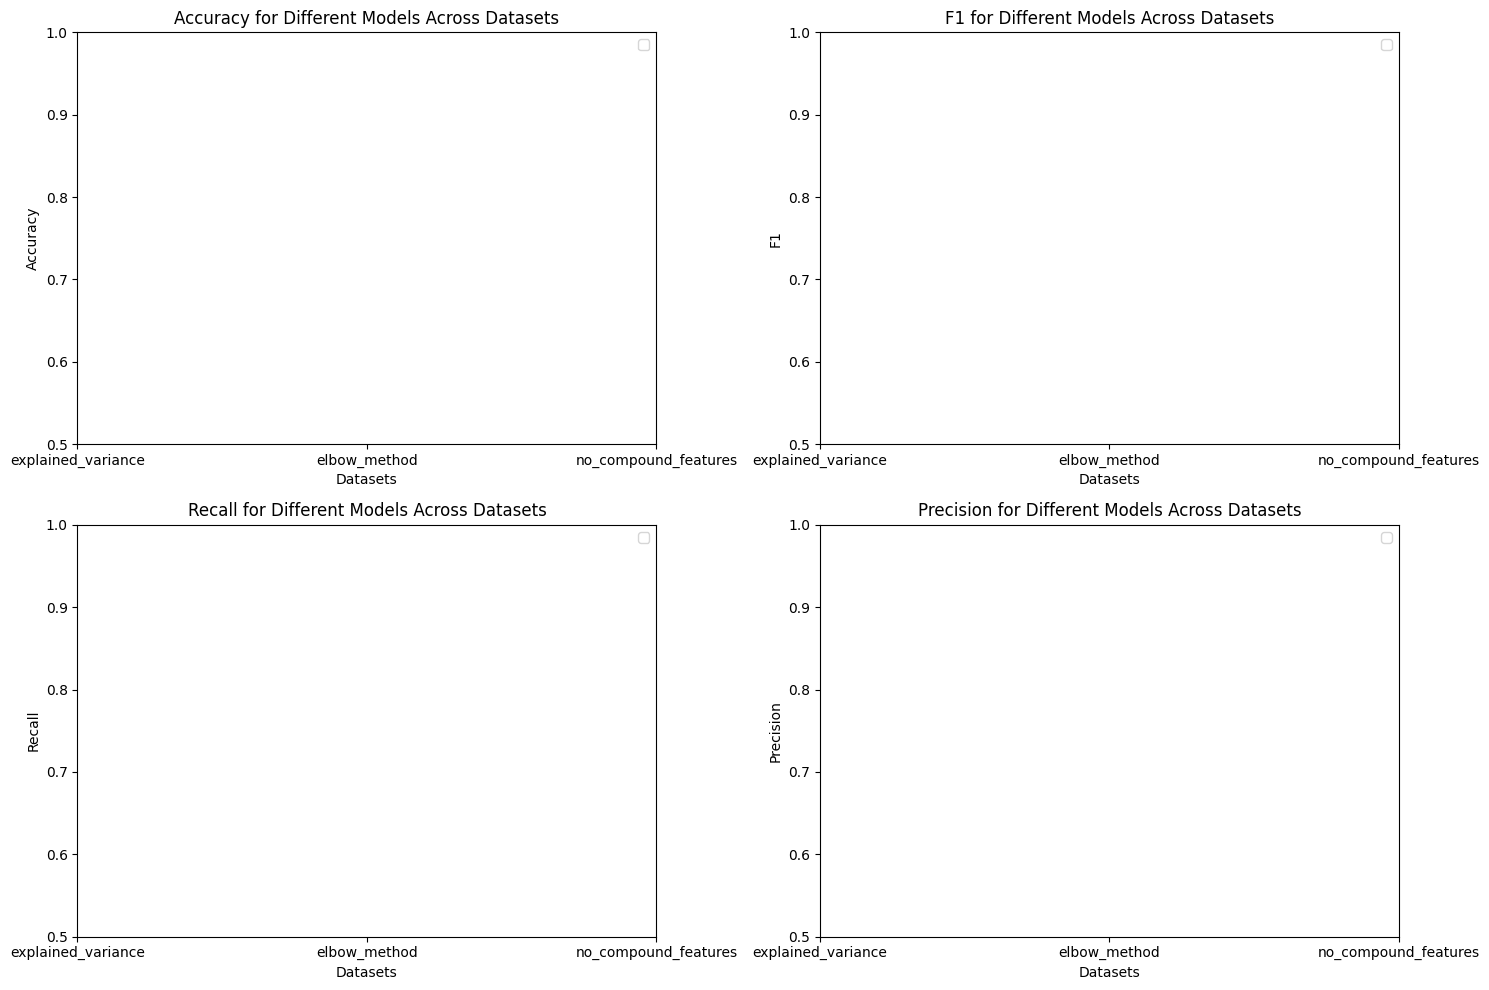

In [10]:
plot_models_results(results, models_name_mapping)